# import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from ast import literal_eval

# loop over and load in behavioural data from useable mirs
def find_organised_path(mir,dat_path):
    dat_path_2 = None
    recording = None
    print(mir)
    for animal_implant in os.listdir(dat_path):
        current_m_i = '_'.join([animal_implant.split('_')[0],animal_implant.split('_')[-1][-1]])
        mi = '_'.join(mir.split('_')[0:-1])
        if current_m_i == mi:
            dat_path_2 = os.path.join(dat_path,animal_implant)
            break
    print(dat_path_2)
    for ind,item in enumerate([record.split('ing')[-1].split('_')[0] for record in os.listdir(dat_path_2)]):
        if item == mir.split('_')[-1]:
            recording = os.listdir(dat_path_2)[ind]
    full_org_dat_path = os.path.join(dat_path_2,recording)
    print(full_org_dat_path)
    return full_org_dat_path



def binned_firing_rate(neuron_spikes, epoch_duration, bin_size=2):
# neuron_spikes is a list or array of spike times (in seconds)
# epoch_duration = total length of recording (in seconds)
# bin_size = width of each bin (e.g. 0.1s)
    bins = np.arange(0, epoch_duration + bin_size, bin_size)
    counts, _ = np.histogram(neuron_spikes, bins=bins)
    rates = counts / bin_size   # convert to Hz
    return rates, bins[:-1]     # rates aligned to bin edges

# Function to compute Fano factor per neuron
# Fano factor = variance / mean of spike counts in time bins
def compute_fano(neuron_spikes, epoch_duration, bin_size=0.1):
    bins = np.arange(0, epoch_duration + bin_size, bin_size)
    counts, _ = np.histogram(neuron_spikes, bins=bins)
    if counts.mean() > 0:
        return counts.var() / counts.mean()
    else:
        return np.nan  # avoid division by zero


In [2]:
# firing rate differences?
# interspike interval differences
# distribution of fano factors
#ISI histogram (linear + log scale) and cumulative ISI CDF — reveals bursting / refractoriness.
#Sparsity measures: population sparsity (Treves–Rolls), lifetime vs population sparseness to see whether activity is distributed or sparse.

# spiking consistency ?
# Population coupling (Okun-style): correlation of each neuron with the instantaneous population rate (excl. the neuron). High population coupling → neuron follows global fluctuations.

# CV and CV2 per neuron (CV2 is less sensitive to slow rate changes).

# Time-resolved Fano/CV (sliding window across session) to see when differences appear.
# Visualization: heatmap of CV per neuron (sorted by mean rate) split by drug.

In [3]:
# load in all the spikes from post sleep for each recording. 
animals = ['seq052_1_1','seq052_1_2','seq052_1_3','seq052_1_4','seq052_1_5','seq052_1_6','seq054_1_2','seq059_1_1','seq059_1_2','seq059_1_3','seq059_1_4','seq059_1_5','seq059_1_6']
group = ['saline','ap5','saline','ap5','saline','ap5','ap5','saline','ap5','saline','ap5','saline','ap5']

base_path = r'Z:\projects\sequence_squad\revision_data\organised_data\animals\\'

sleeptimepoints = pd.read_csv(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\sleep_time_points.csv")

In [4]:
all_data_df = pd.DataFrame({})

for index, animal in enumerate(animals):
    print(index)
    full_org_dat_path = find_organised_path(animal,base_path)
    good_units = pd.read_csv(full_org_dat_path + r'\ephys\probeA\non_curated_spikes\good_units_df.csv')
    multiunits = pd.read_csv(full_org_dat_path + r'\ephys\probeA\non_curated_spikes\multiunits_df.csv')

    # filter spikes and join 
    good_units_str = good_units[good_units.Region == 'striatum']
    multiunits_str = multiunits[multiunits.Region == 'striatum']
    frames = [good_units_str, multiunits_str]
    all_units = pd.concat(frames)
    all_units.reset_index()

    # get epoch start
    sleep_start = sleeptimepoints.approx_sleep_start.values[np.where(sleeptimepoints.mir == animal)][0]
    epoch_start = sleep_start - 500

    ## time filter all the spikes so we only have epoch spikes:
    all_neurons = []
    current_max = 0
    for spike_times in all_units.Spike_times.values:
        spike_times = literal_eval(spike_times)
        
        # filter for times post drug/saline (take anything 500s before first sleep onset)
        spikes = np.array(spike_times)[spike_times > epoch_start]
        all_neurons +=[spikes]
        
        if len(spikes) > 0:
            if max(spikes) > current_max:
                current_max = max(spikes)
        
    epoch_duration = current_max - epoch_start
    
    ### 1. average firing rate
    hz = []
    for neuron_spikes in all_neurons:
        hz += [len(neuron_spikes)/epoch_duration]


    # firing rate over time
    all_rates = []
    for neuron_spikes in all_neurons:
        rates, t = binned_firing_rate(neuron_spikes - epoch_start, epoch_duration, bin_size=2)
        all_rates.append(rates)

    all_rates = np.array(all_rates)   # shape: (n_neurons, n_bins)
    # get mean over time
    mean_fr_over_time = np.mean(all_rates,axis = 0)
    

    # 2. ISIs 
    # Define bins: 0-0.1, 0.1-0.2... 5s + 
    bin_size = 0.1
    max_bin = 30
    bins = np.arange(0, max_bin + bin_size, bin_size)
    bins = np.append(bins, np.inf)  # last bin catches anything >20s


    # Collect all ISIs across neurons
    all_isis = []
    for neuron_spikes in all_neurons:
        neuron_spikes = np.sort(neuron_spikes)
        isis = np.diff(neuron_spikes)
        if len(isis) > 0:
            all_isis.extend([np.mean(isis)])

    all_isis = np.array(all_isis)

    # Compute histogram
    counts, _ = np.histogram(all_isis, bins=bins)

    # Bin centers for plotting (last bin = 20+)
    bin_centers = np.append(bins[:-2] + bin_size/2, max_bin + bin_size/2)

    # # Plot
    # plt.bar(bin_centers, counts, width=bin_size)
    # plt.xlabel("ISI (s)")
    # plt.ylabel("Count")
    # plt.title("Histogram of ISIs across neurons")
    # plt.show()



    ## 3. FANO

    # Compute Fano factors for all neurons
    fano_factors = []
    for neuron_spikes in all_neurons:
        fano = compute_fano(neuron_spikes-epoch_start, epoch_duration, bin_size=0.1)
        if not np.isnan(fano):
            fano_factors.append(fano)

    fano_factors = np.array(fano_factors)

    # Choose bins automatically, or manually, e.g., 0 to 5 or using range of your data
    bins = np.linspace(0, 5, 40)  # 40 bins

    # Histogram
    fano_counts, _ = np.histogram(fano_factors, bins=bins)

    # # Plot
    # bin_centers = bins[:-1] + np.diff(bins)/2
    # plt.bar(bin_centers, fano_counts, width=np.diff(bins))
    # plt.xlabel("Fano factor")
    # plt.ylabel("Number of neurons")
    # plt.title("Distribution of Fano factors")
    # plt.show()



    ################################
    #save out the data

    outdf = pd.DataFrame({'mouse':[animal],'group':[group[index]],'overall_mean':[np.mean(hz)],'mean_hz_overtime': [mean_fr_over_time],
                            'meanISI_binned':[counts/sum(counts)],'fanos_binned':[fano_counts/sum(counts)]})
    frames = [all_data_df, outdf]
    all_data_df = pd.concat(frames)
    
    print('------------- DONE -------------')


0
seq052_1_1
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording1_17-06-2025
------------- DONE -------------
1
seq052_1_2
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording2_18-06-2025
------------- DONE -------------
2
seq052_1_3
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording3_10-07-2025
------------- DONE -------------
3
seq052_1_4
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1
Z:\projects\sequence_squad\revision_data\organised_data\animals\\seq052_implant1\recording4_11-07-2025
------------- DONE -------------
4
seq052_1_5
Z:\projects\sequence_squad\revision_data\organised_data\animals\\se

av firing rate overall 

Text(0.5, 1.0, 'av. firing rate, Saline vs ap5')

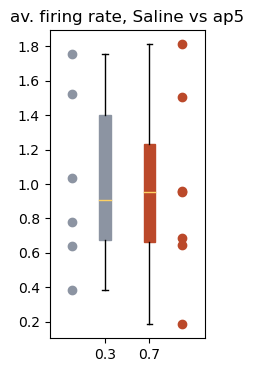

In [5]:
saline_data = all_data_df[all_data_df.group == 'saline']
ap5_data = all_data_df[all_data_df.group == 'ap5']


fig, ax = plt.subplots(figsize=(2, 4))
ax.plot(np.zeros(len(saline_data.overall_mean.values)),saline_data.overall_mean.values,'o', color = "#8C94A2")
ax.boxplot(saline_data.overall_mean.values, positions=[0.3], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#8C94A2', color='#8C94A2'), medianprops=dict(color='#FED163'))

ax.plot(np.ones(len(ap5_data.overall_mean.values)),ap5_data.overall_mean.values,'o', color = "#BB492A")
ax.boxplot(ap5_data.overall_mean.values, positions=[0.7], widths=0.1, patch_artist=True, boxprops=dict(facecolor='#BB492A', color='#BB492A'), medianprops=dict(color='#FED163'))

ax.set_title('av. firing rate, Saline vs ap5')


firing rate over time

Text(0.5, 0, 'time (s)')

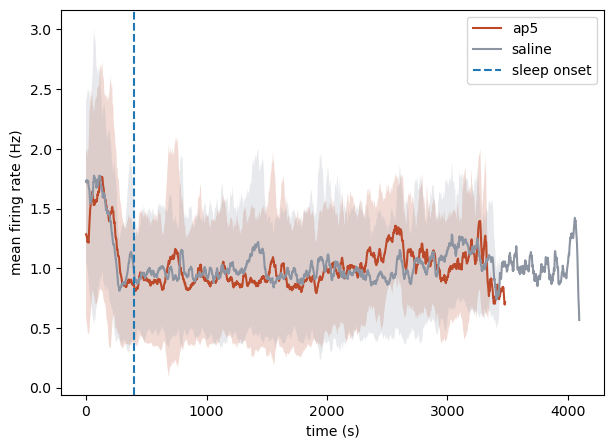

In [6]:
def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def nan_padded_mean_std(arrays):
    # Find the max length
    max_len = max(len(a) for a in arrays)

    # Pad shorter arrays with NaN
    padded = np.array([np.pad(a, (0, max_len - len(a)), constant_values=np.nan) for a in arrays])

    # Column-wise mean ignoring NaNs
    col_means = np.nanmean(padded, axis=0)
    col_std = np.nanstd(padded, axis=0)
    return col_means, col_std

ap5_means, ap5_std = nan_padded_mean_std(ap5_data.mean_hz_overtime.values)
saline_means, saline_std = nan_padded_mean_std(saline_data.mean_hz_overtime.values)

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(convolve_movmean(ap5_means,30), color = '#BB492A', label = 'ap5')
ax.fill_between(range(len(ap5_means)), convolve_movmean(ap5_means,30) - convolve_movmean(ap5_std,30),convolve_movmean(ap5_means,30) + convolve_movmean(ap5_std,30), color = '#BB492A', alpha=0.2, edgecolor='None', linewidth=1, linestyle='dashdot', antialiased=True)

ax.plot(convolve_movmean(saline_means,30), color = '#8C94A2', label = 'saline')
ax.fill_between(range(len(saline_means)), convolve_movmean(saline_means,30) - convolve_movmean(saline_std,30),convolve_movmean(saline_means,30) + convolve_movmean(saline_std,30), color='#8C94A2', alpha=0.2, edgecolor='None', linewidth=1, linestyle='dashdot', antialiased=True)

ax.axvline(400, linestyle = '--', label = 'sleep onset')

ax.legend()
ax.set_ylabel('mean firing rate (Hz)')
ax.set_xlabel('time (s)')



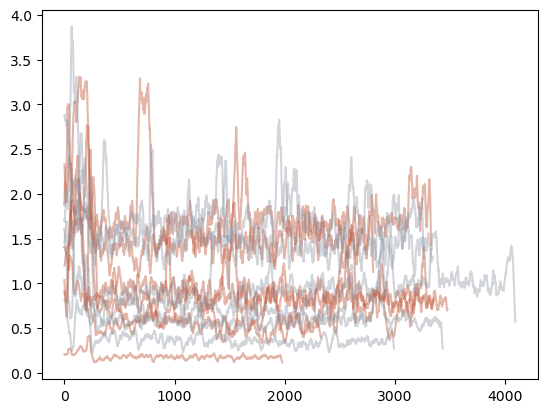

In [7]:
for ap5 in ap5_data.mean_hz_overtime.values:
    plt.plot(convolve_movmean(ap5,30), '#BB492A', alpha = 0.4)
for saline in saline_data.mean_hz_overtime.values:
    plt.plot(convolve_movmean(saline,30), '#8C94A2', alpha = 0.4)

inter spike intervals

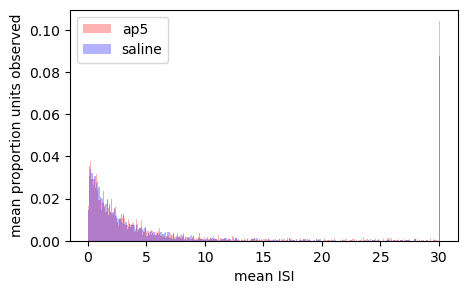

In [8]:

bin_size = 0.1
max_bin = 30
bins = np.arange(0, max_bin + bin_size, bin_size)
bins = np.append(bins, np.inf)  # last bin catches anything >20s
bin_centers = np.append(bins[:-2] + bin_size/2, max_bin + bin_size/2)


# Plot

fig, ax = plt.subplots(figsize=(5, 3))

counts = np.mean(ap5_data.meanISI_binned.values, axis = 0)
ax.bar(bin_centers, counts, width=bin_size, color = 'red', alpha = 0.3, label = 'ap5')
counts = np.mean(saline_data.meanISI_binned.values, axis = 0)
ax.bar(bin_centers, counts, width=bin_size, color = 'blue', alpha = 0.3, label = 'saline')

ax.set_ylabel('mean proportion units observed')
ax.set_xlabel('mean ISI')
ax.legend()

fano distribution

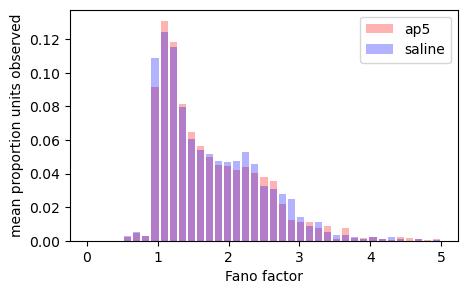

In [9]:
# Choose bins automatically, or manually, e.g., 0 to 5 or using range of your data
bins = np.linspace(0, 5, 40)  # 40 bins
bin_centers = bins[:-1] + np.diff(bins)/2


# Plot

fig, ax = plt.subplots(figsize=(5, 3))

counts = np.mean(ap5_data.fanos_binned.values, axis = 0)
ax.bar(bin_centers, counts, width=bin_size, color = 'red', alpha = 0.3, label = 'ap5')
counts = np.mean(saline_data.fanos_binned.values, axis = 0)
ax.bar(bin_centers, counts, width=bin_size, color = 'blue', alpha = 0.3, label = 'saline')

ax.set_ylabel('mean proportion units observed')
ax.set_xlabel('Fano factor')
ax.legend()

In [ ]:


#spike train irregularity (CV/CV2)

# some kind of population coupling metric, how coupled are neurons with each other on average? 

np.int64(12700)

array([], dtype=float64)

array([13200, 11100, 10300, 12800, 12250, 14170, 11000, 12800, 11000,
       10000,  9470, 10850, 12850])

In [45]:
spike_times

[11096.209366666666,
 11096.2294,
 11097.227366666666,
 11097.247133333334,
 11097.267033333334,
 11097.286833333334,
 11097.3069,
 11097.3268,
 11097.3663,
 11097.386266666666,
 11097.406233333333,
 11097.446166666667,
 11097.525833333333,
 11097.605633333333,
 11097.706133333333,
 11097.745933333334,
 11097.766066666667,
 11102.316966666667,
 11102.3369,
 11102.356966666666,
 11103.355233333334,
 11103.3752,
 11103.475033333334,
 11104.473166666667,
 11104.4929,
 11104.592533333333,
 11104.6325,
 11104.672533333332,
 11104.692466666667,
 11104.712333333333,
 11104.732333333333,
 11104.752233333333,
 11104.772233333333,
 11104.7924,
 11104.812266666666,
 11104.8722,
 11104.9521,
 11105.051866666667,
 11105.1716,
 11105.191433333333,
 11105.211566666667,
 11105.231566666667,
 11105.311266666668,
 11105.331166666667,
 11105.351233333333,
 11105.4112,
 11105.490933333333,
 11105.5109,
 11105.550933333334,
 11105.610833333334,
 11105.670666666667,
 11105.6907,
 11106.528533333334,
 11106.